# 3. Data Visualization
*Note: If you are prompted to select a kernel, please select SageMaker Jumpstart PyTorch 1.0*

In this notebook we will visualize our sample data set.

You can select Run->Run All Cells from the menu to run all cells in Studio (or Cell->Run All in a SageMaker Notebook Instance).

In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 121 kB 24.2 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 67.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 29.6 MB/s eta 0:00:01
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from source.config import Config
from source.visualization.plot_utils import build_chart
from source.dl_utils.dataset import PMDataset_torch

np.random.seed(12345)

%matplotlib inline
plt.style.use('ggplot')
colour_options = ["#81ecec", "#a29bfe", "#fd79a8", "#ffeaa7", "#b2bec3", "#00b894", "#ff7675", "#e84393", "#e17055"]

## Define the data path in the config file

In [3]:
config = Config(filename="config/config.yaml")

## Check the input data

In [4]:
df = pd.read_csv(config.train_dataset_fn)
@interact(x=(0, 20, 1))
def show_articles_more_than(x=10):
    return df.head(x)

interactive(children=(IntSlider(value=10, description='x', max=20), Output()), _dom_classes=('widget-interact'…

## Build the dataset

In [5]:
train_ds = PMDataset_torch(
    config.train_dataset_fn,
    sensor_headers=config.sensor_headers,
    target_column=config.target_column,
    standardize=True)

properties = train_ds.vehicle_properties_headers.copy()
properties.remove('vehicle_id')
properties.remove('timestamp')
properties.remove('period_ms')

Creating PMDataset: data/processed/train_dataset.csv
  * Loading CSV data
voltage mean is 13.6713+0.3879
current mean is 0.1704+0.0777
Done


## Visualize data statistics

interactive(children=(Dropdown(description='value1', options=('make', 'model', 'year', 'vehicle_class', 'engin…

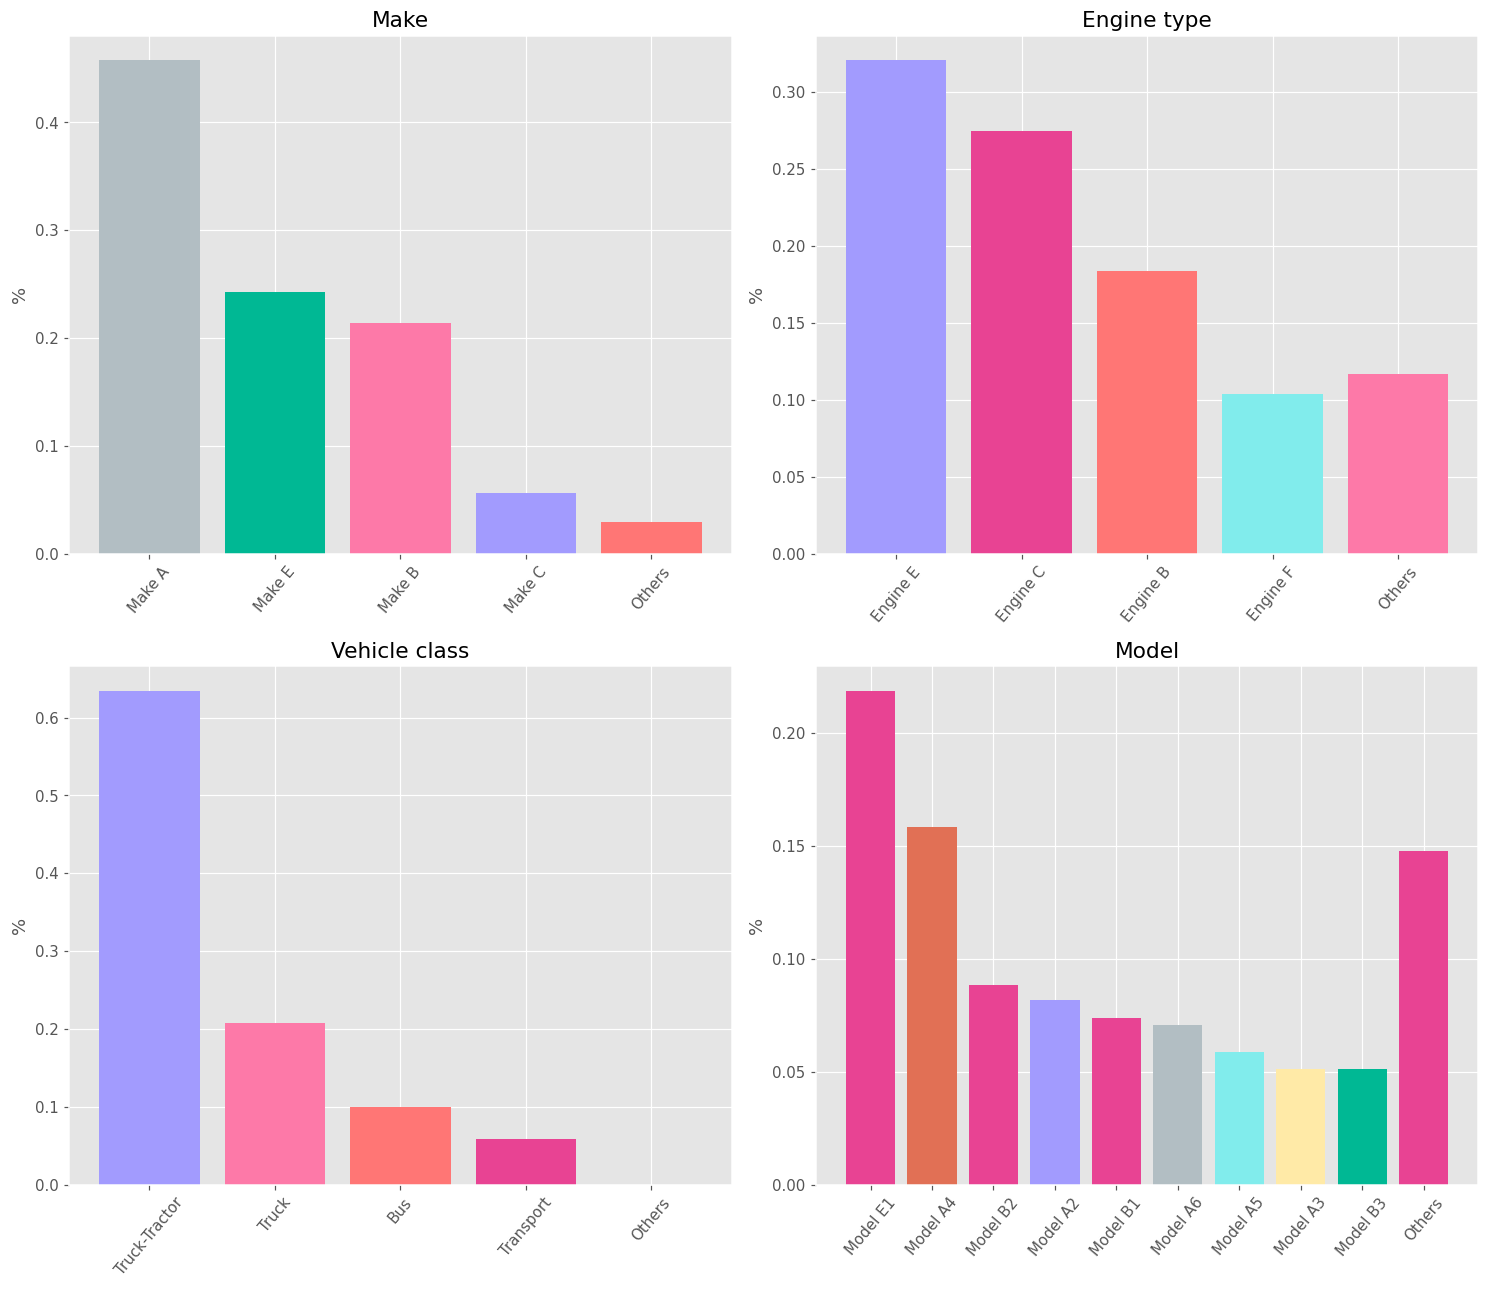

In [6]:
[default1, default2, default3, default4] = np.random.choice(properties, size=4, replace=False).tolist()

def show_chart(
    value1=default1, 
    value2=default2, 
    value3=default3, 
    value4=default4):
    
    coords = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
    fig1, ax = plt.subplots(2, 2, figsize=(1500/108, 1300/108), dpi=108)
    
    for idx, value in enumerate([value1, value2, value3, value4]):
        coord = coords[idx]
        labels, sizes = build_chart(train_ds.vehicle_properties[value])
        x_pos = [i for i, _ in enumerate(labels)]
        colors = np.random.choice(colour_options, size=len(sizes))
        ax[coord[0], coord[1]].bar(x_pos, sizes, color=colors)
        ax[coord[0], coord[1]].set_xticks(x_pos)
        ax[coord[0], coord[1]].set_xticklabels(labels, rotation=50)
        ax[coord[0], coord[1]].set_title(value.capitalize().replace("_", " "))
        ax[coord[0], coord[1]].set_ylabel("%")
    
    fig1.tight_layout()
widgets.interactive(
    show_chart, 
    value1=properties,
    value2=properties,
    value3=properties,
    value4=properties)

## Visualize the specific breakdown of the data
### A more detail breakdown of the data is shown. For example, the different models of freightliners, or different models in a given year.

interactive(children=(Dropdown(description='property1', options=('make', 'model', 'year', 'vehicle_class', 'en…

<function __main__.bd_update_plot(property1, value1, property2)>

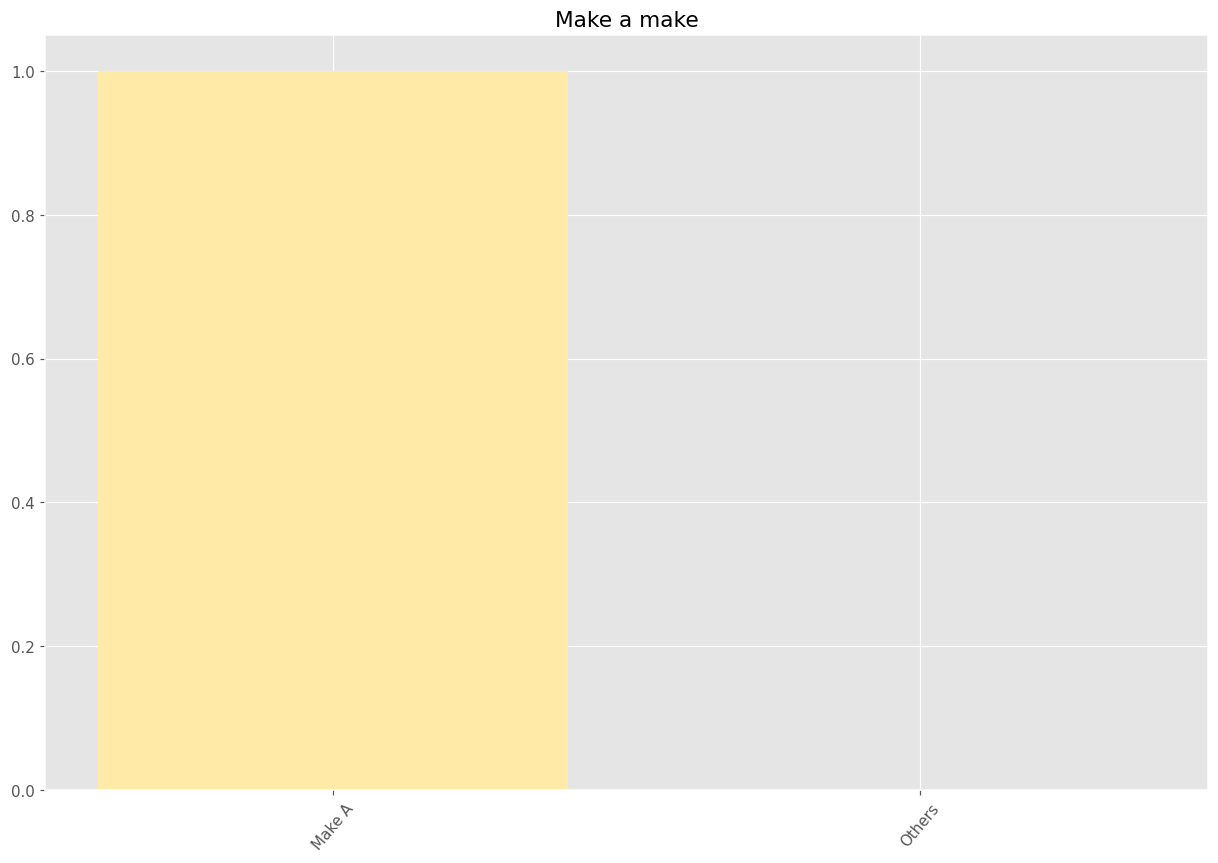

In [7]:
def bd_update_plot(property1, value1, property2):
    fig1 = plt.figure(figsize=(1500/108, 1000/108), dpi=108)

    labels, sizes = build_chart(train_ds.select_data(**{property1: value1}).vehicle_properties[property2])
    x_pos = [i for i, _ in enumerate(labels)]
    colors = np.random.choice(colour_options, size=len(sizes))
    plt.bar(x_pos, sizes, color=colors)
    plt.xticks(x_pos, labels, rotation=50)
    plt.title("{} {}".format(str(value1).capitalize(), str(property2).lower()))

bd_target_default = random.choice(properties)
bd_target_selector = widgets.Dropdown(options=properties, value=bd_target_default)
bd_target_value_selector = widgets.Dropdown()
bd_secondary_selector = widgets.Dropdown(options=properties, value=random.choice(properties))

def bd_update_selector(*args):
    bd_target_value_selector.options = train_ds.vehicle_properties[bd_target_selector.value].unique().tolist()
bd_target_selector.observe(bd_update_selector)
bd_update_selector()

widgets.interact(bd_update_plot, property1=bd_target_selector, value1=bd_target_value_selector, property2=bd_secondary_selector)

## Log data comparison
### An example of comparing between the means of two log data are between different years

interactive(children=(Dropdown(description='target', index=3, options=('make', 'model', 'year', 'vehicle_class…

<function __main__.log_update_plot(target, target_value1, target_value2)>

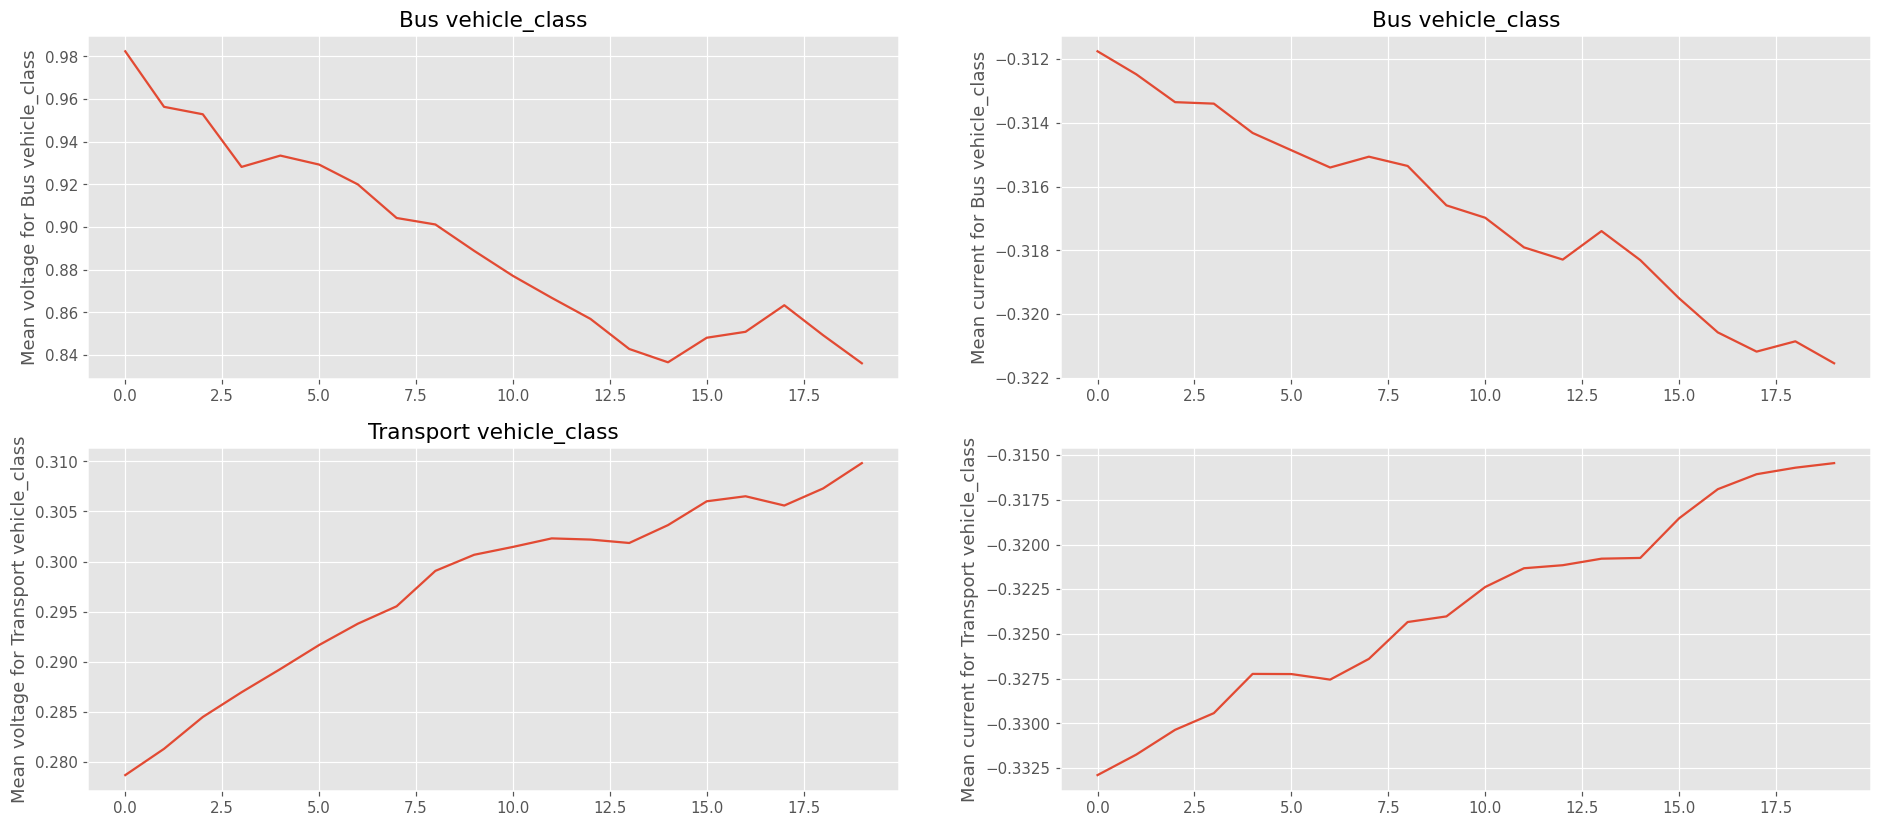

In [8]:
target_default = random.choice(properties)
log_target_selector = widgets.Dropdown(options=properties, value=target_default)
log_target_value1_selector = widgets.Dropdown()
log_target_value2_selector = widgets.Dropdown()

def log_update_selector(*args):
    log_target_value1_selector.options = train_ds.vehicle_properties[log_target_selector.value].unique().tolist()
    log_target_value1_selector.value = random.choice(log_target_value1_selector.options)
    log_target_value2_selector.options = train_ds.vehicle_properties[log_target_selector.value].unique().tolist()
    log_target_value2_selector.value = random.choice(log_target_value2_selector.options)

log_target_selector.observe(log_update_selector)
log_update_selector()

def log_update_plot(target, target_value1, target_value2):
    fig, axs = plt.subplots(2, len(config.sensor_headers), figsize=(2300/108, 1000/108), dpi=108)
    axs[0, 0].set_title("{} {}".format(target_value1, target))
    axs[1, 0].set_title("{} {}".format(target_value2, target))

    for i, sensor_header in enumerate(config.sensor_headers):
        data_1 = train_ds.select_data(**{target: target_value1}).data.mean(0)
        
        axs[0, i].plot(data_1[:, i])
        axs[0, i].set_title("{} {}".format(target_value1, target))
        axs[0, i].set_ylabel("Mean {} for {} {}".format(sensor_header, target_value1, target))

        data_2 = train_ds.select_data(**{target: target_value2}).data.mean(0)
        axs[1, i].plot(data_2[:, i])
        axs[1, i].set_ylabel("Mean {} for {} {}".format(sensor_header, target_value2, target))

widgets.interact(log_update_plot, target=log_target_selector, target_value1=log_target_value1_selector, target_value2=log_target_value2_selector)

### Then we breakdown the means of the log data

interactive(children=(Dropdown(description='target1', index=3, options=('make', 'model', 'year', 'vehicle_clas…

<function __main__.log2_update_plot(target1, target1_value, target2, target2_compare1, target2_compare2)>

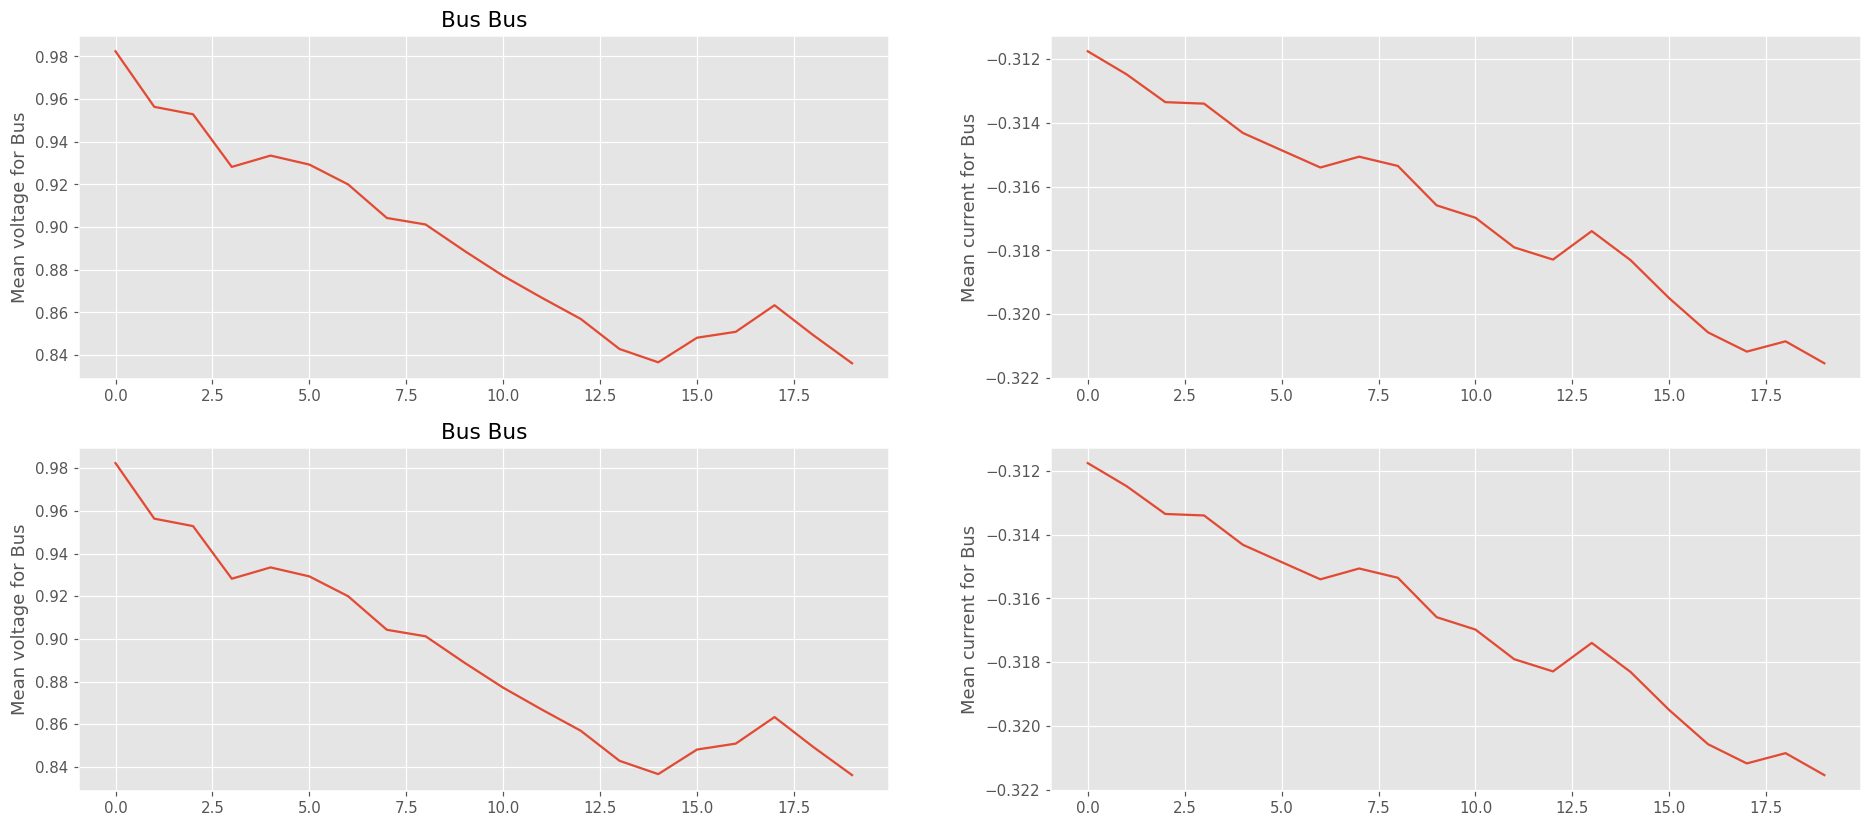

In [9]:
target_default = random.choice(properties)
log2_target1_selector = widgets.Dropdown(options=properties, value=target_default)
log2_target1_value_selector = widgets.Dropdown()

log2_target2_selector = widgets.Dropdown(options=properties, value=target_default)
log2_target2_value1_selector = widgets.Dropdown()
log2_target2_value2_selector = widgets.Dropdown()

def log2_target1_update_selector(*args):
    log2_target1_value_selector.options = train_ds.vehicle_properties[log2_target1_selector.value].unique().tolist()
    log2_target1_value_selector.value = random.choice(log2_target1_value_selector.options)

log2_target1_selector.observe(log2_target1_update_selector)
log2_target1_update_selector()

def log2_target2_update_selector(*args):
    log2_target2_value1_selector.options = train_ds.vehicle_properties[log2_target2_selector.value].unique().tolist()
    log2_target2_value1_selector.value = random.choice(log2_target2_value1_selector.options)
    log2_target2_value2_selector.options = train_ds.vehicle_properties[log2_target2_selector.value].unique().tolist()
    log2_target2_value2_selector.value = random.choice(log2_target2_value1_selector.options)

log2_target2_selector.observe(log2_target2_update_selector)
log2_target2_update_selector()


def log2_update_plot(target1, target1_value, target2, target2_compare1, target2_compare2):
    fig, axs = plt.subplots(2, len(config.sensor_headers), figsize=(2300/108, 1000/108), dpi=108)
    
    axs[0, 0].set_title("{} {}".format(target1_value, target2_compare1))
    axs[1, 0].set_title("{} {}".format(target1_value, target2_compare2))

    for i, sensor_header in enumerate(config.sensor_headers):
        data_1 = train_ds.select_data(**{target1: target1_value, target2: target2_compare1}).data.mean(0)
        
        axs[0, i].plot(data_1[:, i])
        axs[0, i].set_ylabel("Mean {} for {}".format(sensor_header, target2_compare1))

        data_2 = train_ds.select_data(**{target1: target1_value, target2: target2_compare2}).data.mean(0)
        axs[1, i].plot(data_2[:, i])
        axs[1, i].set_ylabel("Mean {} for {}".format(sensor_header, target2_compare2))
    
widgets.interact(log2_update_plot, target1=log2_target1_selector, target1_value=log2_target1_value_selector, target2=log2_target2_selector, target2_compare1=log2_target2_value1_selector, target2_compare2=log2_target2_value2_selector)

## Visualize an example

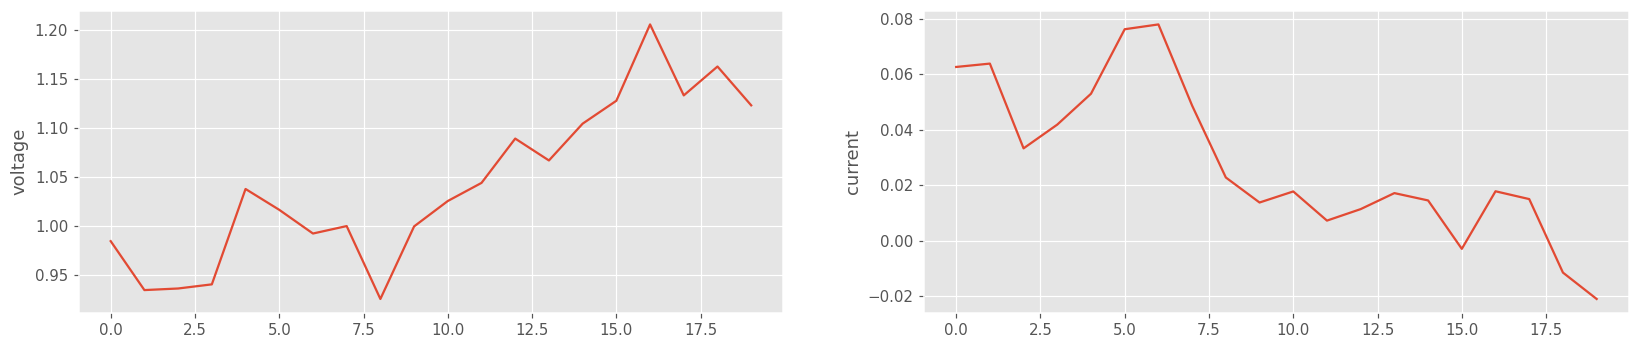

In [10]:
data, label = train_ds[0]
fig, axs = plt.subplots(1, len(config.sensor_headers), figsize=(2000/108, 400/108), dpi=108)

for i, sensor_header in enumerate(config.sensor_headers):
    axs[i].plot(data[:, i])
    axs[i].set_ylabel("{}".format(sensor_header))

## Next Stage
Up next we'll train a model on the sample data. [Click here to continue](./4_model_training.ipynb).